# NetworkX - Easy Graph Analytics

NetworkX is the most popular library for graph analytics available in Python, or quite possibly any language. To illustrate this, NetworkX was downloaded more than 80 million times in September of 2024 alone, which is roughly 50 times more than the next most popular graph analytics library! [*](https://en.wikipedia.org/wiki/NetworkX) NetworkX has earned this popularity from its very easy-to-use API, the wealth of documentation and examples available, the large (and friendly) community behind it, and its easy installation which requires nothing more than python.

However, NetworkX users are familiar with the tradeoff that comes with those benefits. The pure-Python implementation often results in poor performance when graph data starts to reach larger scales, limiting the usefulness of the library for many real-world problems.

# Accelerated NetworkX - Easy (and fast!) Graph Analytics

To address the performance problem, NetworkX 3.0 introduced a mechanism to dispatch algorithm calls to alternate implementations. The NetworkX Python API remains the same but NetworkX will use more capable algorithm implementations provided by one or more backends. This approach means users don't have to give up NetworkX -or even change their code- in order to take advantage of GPU performance.

# Let's Get the Environment Setup
This notebook will demonstrate NetworkX both with and without GPU acceleration provided by the `nx-cugraph` backend.

`nx-cugraph` is available by default in Colab, but we'll include the install step anyway to show you how it can be installed elsewhere.

`nx-cugraph` is available as a package installable using `pip`, `conda`, and [from source](https://github.com/rapidsai/nx-cugraph).  Before importing `networkx`, lets install `nx-cugraph` so it can be registered as an available backend by NetworkX when needed.  We'll use `pip` to install.

NOTES:
* `nx-cugraph` requires a compatible NVIDIA GPU, NVIDIA CUDA, its associated drivers, and a supported OS. Details about these and other installation prerequisites can be seen [here](https://docs.rapids.ai/install#system-req).
* The `nx-cugraph` package is currently hosted by NVIDIA, therefore the `--extra-index-url` option must be used.
* `nx-cugraph` is supported on specific 11.x and 12.x CUDA versions, and the major version number must be known in order to install the correct build (this is determined automatically when using `conda`).

To find the CUDA major version on your system, run the following command:

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


From the above output we can see that we're using CUDA 12.x so we'll be installing `nx-cugraph-cu12`. If we were using CUDA 11.x the package name would be `nx-cugraph-cu11`. We'll also be adding `https://pypi.nvidia.com` as an `--extra-index-url`:

In [ ]:
!pip install nx-cugraph-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


Of course, we'll also be using `networkx`, which is also pre-installed in the Colab environment. This notebook will be using features added in version 3.4, so we'll import it here to verify we have a compatible version.

We'll also set the `NX_CUGRAPH_AUTOCONFIG` environment variable that is read by nx-cugraph (version 24.10 and newer) on initialization which will configure NetworkX to use the "cugraph" backend by default. This variable is unique to the cuGraph backend and must be set prior to importing `networkx`.

Finally, this notebook will automatically use a NetworkX caching feature. This is enabled by default in NetworkX, but does produce a courtesy warning for certain users that modify the graph in ways no longer recommended. You can re-enable the warning to see more details, but this notebook uses only recommended APIs and the warning does not apply here.

In [2]:
%env NX_CUGRAPH_AUTOCONFIG=True

import networkx as nx
print(f"using networkx version {nx.__version__}")

nx.config.warnings_to_ignore.add("cache")

env: NX_CUGRAPH_AUTOCONFIG=True
using networkx version 3.4.2


# Let's Start with Something Simple

To begin, we'll compare NetworkX results from the same algorithm with and without a backend on a small graph.  `nx.karate_club_graph()` returns an instance of the famous example graph consisting of 34 nodes and 78 edges from Zachary's paper, described [here](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

## Betweenness Centrality
[Betweenness Centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) is a graph algorithm that computes a centrality score for each node (`v`) based on how many of the shortest paths between pairs of nodes in the graph pass through `v`. A higher centrality score represents a node that "connects" other nodes in a network more than that of a node with a lower score.

First, let's create a NetworkX Graph instance of the the Karate Club graph and inspect it.

In [3]:
G = nx.karate_club_graph()
G.number_of_nodes(), G.number_of_edges()

(34, 78)

Next, let's run betweenness centrality and save the results.

In [4]:
%%time
nxcg_bc_results = nx.betweenness_centrality(G)

CPU times: user 115 ms, sys: 48.6 ms, total: 163 ms
Wall time: 501 ms


Now, let's run the same algorithm without using a backend.

There are several ways to instruct NetworkX to use a particular backend, as seen in the NetworkX tutorial [here](https://networkx.org/documentation/stable/tutorial.html#using-networkx-backends).  We used the `NX_CUGRAPH_AUTOCONFIG` environment variable, which is unique to `nx-cugraph`.  Another way that works well for examples like this is to use the `backend=` keyword argument.

The following line will use `backend="networkx"` to run with the default NetworkX implementation instead of the "cugraph" backend.

Some notes:
* The standard convention for NetworkX backends is to name the package with a `nx-` prefix to denote they're packages intended to be used with NetworkX, but the `nx-` prefix is not included when referring to them in NetworkX API calls. Here, `nx-cugraph` is the name of the backend package and `"cugraph"` is the name NetworkX will use to refer to it.
* The backend named `"networkx"` refers to the default NetworkX implementation, and is not a backend that needs to be installed separately.

In [5]:
%%time
nx_bc_results = nx.betweenness_centrality(G, backend="networkx")

CPU times: user 200 ms, sys: 8.78 ms, total: 209 ms
Wall time: 205 ms


You may have noticed that using the default implementation was slightly faster. This is not suprising when working with a graph this small, since the overhead of launching the algorithm kernel on the GPU is more than the computation time itself in this case.  We'll see later on that this overhead is negligable when compared to the time we can save by running on the GPU when using large data.

Smaller graphs are easy to visualize with NetworkX's plotting utilities. The flexibility of NetworkX's `Graph` instances make it trivial to add the betweenness centrality scores back to the graph object as attributes of the nodes. This will allow us to use those values in the visualization.

In this case, we'll create new attributes for each node called "nx_bc" for the default NetworkX results, and "nxcg_bc" for the nx-cugraph results. We'll use those values to assign the color for each node and plot two graphs side-by-side. This will make it easy to visually validate that the nodes with the higher centrality scores for both implementations match and do indeed appear to be more "central" to the other nodes.

In [6]:
nx.set_node_attributes(G, nxcg_bc_results, "nxcg_bc")
nx.set_node_attributes(G, nx_bc_results, "nx_bc")

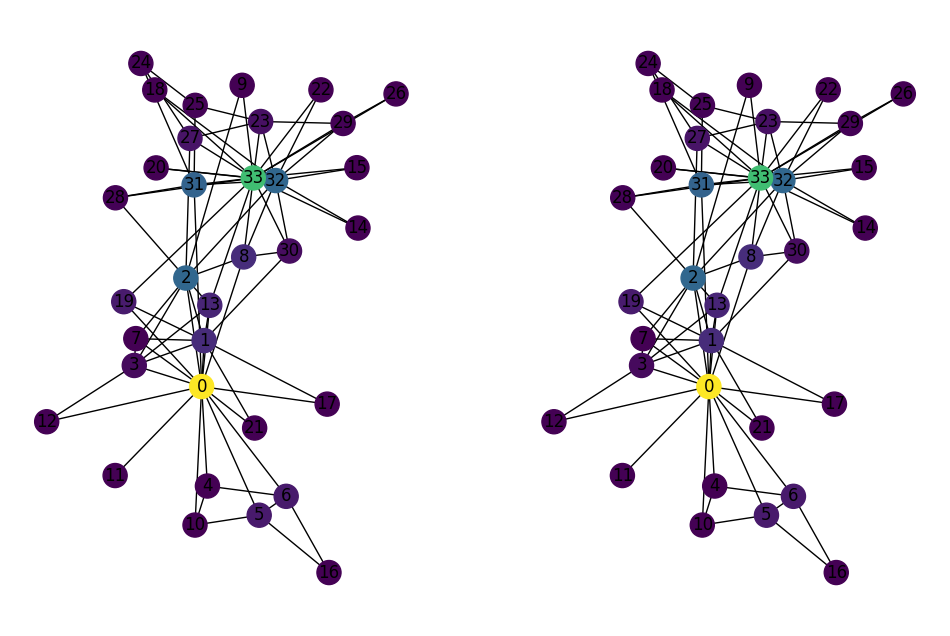

In [7]:
# Configure plot size and layout/position for each node
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
pos = nx.spring_layout(G)

# Assign colors for each set of betweenness centrality results
nx_colors = [G.nodes[n]["nx_bc"] for n in G.nodes()]
nxcg_colors = [G.nodes[n]["nxcg_bc"] for n in G.nodes()]

# Plot the graph and color each node corresponding to NetworkX betweenness centrality values
plt.subplot(1, 2, 1)
nx.draw(G, pos=pos, with_labels=True, node_color=nx_colors)

# Plot the graph and color each node corresponding to nx-cugraph betweenness centrality values
plt.subplot(1, 2, 2)
nx.draw(G, pos=pos, with_labels=True, node_color=nxcg_colors)

As we can see, the same two nodes (`0` and `33`) are the two most central in both graphs, followed by `2`, `31`, and `32`.

## PageRank
Another popular graph algorithm is [PageRank](https://en.wikipedia.org/wiki/PageRank). PageRank also assigns scores to each node, but these scores are based on analyzing links to every other node to determine relative "importance" within the graph.

Let's compare the PageRank results from the cugraph backend to that of the default implementation on the same graph.

In [ ]:
%%time
nxcg_pr_results = nx.pagerank(G)

CPU times: user 20.3 ms, sys: 11.8 ms, total: 32.1 ms
Wall time: 108 ms


In [ ]:
%%time
nx_pr_results = nx.pagerank(G, backend="networkx")

CPU times: user 8.06 ms, sys: 1.02 ms, total: 9.08 ms
Wall time: 29.4 ms


Instead of plotting the graph to show that the results are identical, we'll compare them directly using the saved values from both runs.

*Note: Because we are running in a Colab environment with GPU access, we will have `cudf` preinstalled. `cudf` is a GPU accelerated DataFrame library which can be used to speed up Pandas DataFrame operations. Simply add `%load_ext` before importing `pandas` to enable `cudf.pandas`.*

In [8]:
%load_ext cudf.pandas
import pandas as pd
import pytest
from IPython.display import display, HTML

print("Do both results have the same values (within tolerance)? "
      f"{nxcg_pr_results == pytest.approx(nx_pr_results, rel=1e-6, abs=1e-11)}")

df = pd.DataFrame(
    columns=["nx node", "nxcg node", "nx PR", "nxcg PR"],
    data=[(a, c, b, d) for (a, b), (c, d) in zip(nx_pr_results.items(),
                                                 nxcg_pr_results.items())])
df.sort_values(by="nx PR", ascending=False, inplace=True)

print("\nTop 5 nodes based on PageRank")
display(HTML(df.head(5).to_html(float_format=lambda f: f"{f:.7g}")))
print("\nBottom 5 nodes based on PageRank")
display(HTML(df.tail(5).to_html(float_format=lambda f: f"{f:.7g}")))

NameError: name 'nxcg_pr_results' is not defined

# Working with Bigger Data

In [ ]:
# The locale encoding may have been modified from the plots above, reset here in
# order to run the shell commands below
import locale
locale.getpreferredencoding = lambda: "UTF-8"

Now we'll look at a larger dataset from https://snap.stanford.edu/data/cit-Patents.html containing citations between U.S. patents granted from January 1, 1963 to December 30, 1999. The dataset represents 16.5M citations (edges) between 3.77M patents (nodes).

Data of this size starts to push the limits of the default pure-python, single-threaded NetworkX implementation.

Note: _the dataset is available as a compressed file from `snap.stanford.edu` and will require additional arguments to uncompress it and skip headers. The same data is available uncompressed and without headers from `data.rapids.ai`. We've included code to demonstrate both approaches below._

In [ ]:
# Choose dataset from snap.stanford.edu or data.rapids.ai, update cells below accordingly
# !wget https://snap.stanford.edu/data/cit-Patents.txt.gz  # Skip if cit-Patents.txt.gz already exists
!wget https://data.rapids.ai/cugraph/datasets/cit-Patents.csv  # Skip if cit-Patents.csv already exists

--2024-10-27 21:28:44--  https://data.rapids.ai/cugraph/datasets/cit-Patents.csv
Resolving data.rapids.ai (data.rapids.ai)... 3.169.55.66, 3.169.55.13, 3.169.55.113, ...
Connecting to data.rapids.ai (data.rapids.ai)|3.169.55.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261652279 (250M) [text/csv]
Saving to: ‘cit-Patents.csv’

cit-Patents.csv     100%[===================>] 249.53M   276MB/s    in 0.9s    

2024-10-27 21:28:46 (276 MB/s) - ‘cit-Patents.csv’ saved [261652279/261652279]



In [ ]:
# %%time
# Comment this cell if using dataset from data.rapids.ai
# df = pd.read_csv("cit-Patents.txt.gz",
#                  compression="gzip",
#                  skiprows=4,
#                  sep="\t",
#                  names=["src", "dst"],
#                  dtype="int32",
# )

In [ ]:
%%time
# Comment this cell if using dataset from snap.stanford.edu
df = pd.read_csv("cit-Patents.csv",
                sep=" ",
                names=["src", "dst"],
                dtype="int32",
)

CPU times: user 186 ms, sys: 193 ms, total: 379 ms
Wall time: 520 ms


In [ ]:
%%time
G = nx.from_pandas_edgelist(df, source="src", target="dst")
G.number_of_nodes(), G.number_of_edges()

CPU times: user 1min 16s, sys: 4.68 s, total: 1min 21s
Wall time: 1min 21s


(3774768, 16518948)

By default, `nx.betweenness_centrality` will perform an all-pairs shortest path analysis when determining the centrality scores for each node. However, due to the large size of this graph, determining the shortest path for all pairs of nodes is not feasible. Instead, we'll use the parameter `k` to limit the number of shortest path computations used for determining the centrality scores (at the expense of accuracy). As we'll see when using a dataset this size with `nx.betweenness_centrality`, we have to limit `k` to `1` when using the default NetworkX implementation, which is not practical but is sufficient here for demonstration purposes (since anything larger than `1` will result in many minutes of execution time using unaccelerated NetworkX).

In [ ]:
%%time
bc_results = nx.betweenness_centrality(G, k=1, backend="networkx")

CPU times: user 1min 21s, sys: 2.87 s, total: 1min 24s
Wall time: 1min 23s


Now we'll allow NetworkX to use the `cugraph` backend and run the same call. (reminder: this will happen by default in this session since we used the `NX_CUGRAPH_AUTOCONFIG=True` env setting).

In [ ]:
%%time
bc_results = nx.betweenness_centrality(G, k=1)

CPU times: user 1.02 s, sys: 253 ms, total: 1.27 s
Wall time: 1.28 s


Let's run betweenness centrality again with a more useful number of samples by setting `k=100`.

In [ ]:
%%time
bc_results = nx.betweenness_centrality(G, k=100)

CPU times: user 27.2 s, sys: 960 ms, total: 28.2 s
Wall time: 27.5 s


*Note: you may have noticed we're not comparing the results between NetworkX and nx-cugraph for `betweenness_centrality` when using a large graph that requires the use of a `k` parameter. This is because `betweenness_centrality` is an approximation algorithm based on `k` randomly-selected node samples used for the shortest path calculations. When `k=None` (the default) all nodes in the graph are used, and we'll have deterministic results we can compare. As seen above, we were able to compare results for the smaller graph using the default `k=None` value and the above plots, but larger graphs typically require a `k` value to limit sampling to a reasonable size for more practical run times. In general, the larger the value of `k`, the more accurate the results, and the use of `nx-cugraph` allows for much higher `k` values than the default NetworkX implementation can process in a reasonable amount of time.*

*There is also a `seed` parameter which can be used to provide determinism when selecting node samples when `k` is specified. However, the current version of nx-cugraph uses a separate GPU-optimized random number generator, which also accepts a `seed` value, but maintains a different random number generation state that will likely not match the NetworkX implementation. Future versions of `betweenness_centrality` for nx-cugraph may be updated to use the same randomly-selected node samples as NetworkX, but until then we won't be able to do a meaningful comparison of the results when using `k` values this small.*

Now, let's also run PageRank on the same dataset to compare.

In [ ]:
%%time
nx_pr_results = nx.pagerank(G, backend="networkx")

CPU times: user 1min 58s, sys: 7.76 s, total: 2min 6s
Wall time: 2min 4s


In [ ]:
%%time
nxcg_pr_results = nx.pagerank(G)

CPU times: user 781 ms, sys: 390 ms, total: 1.17 s
Wall time: 1.22 s


In [ ]:
print("Do both results have the same values (within tolerance)? "
      f"{nxcg_pr_results == pytest.approx(nx_pr_results, rel=1e-6, abs=1e-11)}")

df = pd.DataFrame(
    columns=["nx node", "nxcg node", "nx PR", "nxcg PR"],
    data=[(a, c, b, d) for (a, b), (c, d) in zip(nx_pr_results.items(),
                                                 nxcg_pr_results.items())])
df.sort_values(by="nx PR", ascending=False, inplace=True)

print("\nTop 5 nodes based on PageRank")
display(HTML(df.head(5).to_html(float_format=lambda f: f"{f:.7g}")))
print("\nBottom 5 nodes based on PageRank")
display(HTML(df.tail(5).to_html(float_format=lambda f: f"{f:.7g}")))

Do both results have the same values (within tolerance)? True

Top 5 nodes based on PageRank


,nx node,nxcg node,nx PR,nxcg PR
2475029,2475029,2475029,2.70305e-05,2.70305e-05
2475036,2475036,2475036,2.202095e-05,2.202095e-05
3445863,3445863,3445863,1.781009e-05,1.78101e-05
3391975,3391975,3391975,1.764496e-05,1.764497e-05
3106961,3106961,3106961,1.460267e-05,1.460266e-05



Bottom 5 nodes based on PageRank


,nx node,nxcg node,nx PR,nxcg PR
868220,868220,868220,4.007821e-08,4.00782e-08
1043970,1043970,1043970,4.00398e-08,4.003979e-08
799764,799764,799764,4.00398e-08,4.003979e-08
1063143,1063143,1063143,4.00398e-08,4.003979e-08
72674,72674,72674,4.002998e-08,4.002998e-08


## Conclusion
As you can see, with larger graphs (often in the range of 100k nodes and 1M edges and larger) the default NetworkX implementation starts to really impact productivity. But thanks to NetworkX backends and cuGraph, the same easy-to-use NetworkX code can run much faster without code changes, allowing you to use existing workflows on much larger data.

---
<i>
Each user is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
<i>
<br>
<br>
<i>
Information on the U.S. Patent Citation Network dataset used in this notebook is as follows:
<br>Authors: Jure Leskovec and Andrej Krevl
<br>Title: SNAP Datasets, Stanford Large Network Dataset Collection
<br>URL: http://snap.stanford.edu/data
<br>Date: June 2014
</i>
